In [1]:
from lib_linear import *
import time
import torch.nn.functional as F
from copy import deepcopy



## read diagonalized iinput-input, input-output and output-output matrices

In [2]:
input_input_matrix = np.array(pd.read_csv('input_input_matrix.csv'))
output_input_matrix = np.array(pd.read_csv('output_input_matrix.csv'))
output_output_matrix = np.array(pd.read_csv('output_output_matrix.csv'))

V_matrix = np.array(pd.read_csv('V_matrix.csv'))
U_matrix = np.array(pd.read_csv('U_matrix.csv'))
S31_matrix = np.array(pd.read_csv('S_matrix.csv'))  ##actually, just diag values

S11_matrix = V_matrix.T @ input_input_matrix @ V_matrix
S33_matrix = output_output_matrix

S_improved  = pd.read_csv('300/S_improved.csv')
S11_improved = np.array(S_improved['S11'])
S31_improved = np.array(S_improved['S31'])

## Data

In [3]:
mean, std = calculate_mean_and_std()
train_data, test_data =  download_normalized_data(mean, std)

batch_size: int = 1000
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size) 
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

## Neural network model

In [4]:
class CustomNetwork(object):
    
    """
    Simple D-layer linear neural network 
    hidden_dims = topule(n0, n1, n2, ...nD)
    n0 = input layer
    n_D = output layer
    """
    
    def __init__(self, D, layers_dim):
        
        """
        Initialize network's weights according to Gaussian iid and network's biases with 0.0 values
        """
        
        self.weights = []
        self.D = len(layers_dim)-1
        assert self.D == D
                
        for i in range(self.D):
            weight: torch.Tensor = torch.rand((layers_dim[i+1], layers_dim[i])) 
            stdv = 2/ np.sqrt(layers_dim[i])
            weight = (weight-0.5)*stdv
            weight.requires_grad = True
            self.weights.append(weight)
    
            
    def __call__(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass through the network
        """
        for i in range(0,self.D):            
            x = torch.nn.functional.linear( input = x, weight=self.weights[i])
        return x 
    
    
    def parameters(self) -> List[torch.Tensor]:
        """
        Returns all trainable parameters 
        """
        return self.weights

In [5]:
input_dim = 784
output_dim = 10
hidden_dim1 = 300
D = 2
model: CustomNetwork = CustomNetwork(D = D, layers_dim = (input_dim, hidden_dim1, output_dim))

## Training parameters

In [6]:
# initialize the optimizer using the hyperparams below
lr: float = 0.005
momentum: float = 0.00
optimizer: torch.optim.Optimizer = SGD(params = model.parameters(), lr=lr)
criterion = nn.MSELoss() 
epoch: int = 3000

In [7]:
term_I_tab=[]
term_II_tab = []
term_IV_tab = []

term_I_star_tab=[]
term_II_star_tab = []
term_IV_star_tab = []

term_I_diamond_tab=[]
term_II_diamond_tab = []
term_IV_diamond_tab = []

## Training loop

In [8]:
for e in range(epoch):
    for inner_counter, (x, y) in enumerate(train_loader):

        optimizer.zero_grad()
        output: torch.Tensor = model(x)  
        y=F.one_hot(y, num_classes=10).float()
        loss: torch.Tensor = criterion(output, y)
        loss.backward()
        optimizer.step()     
    
    #add model parameters to tab
    loss_tab.append(loss.item())
    params_tab = []
    for param in model.parameters():
        params_tab.append(param.detach().numpy().flatten()  )
    w1_mean_tab.append(params_tab[0].mean())
    w2_mean_tab.append(params_tab[1].mean())
    w1_std_tab.append(params_tab[0].std())
    w2_std_tab.append(params_tab[1].std())

    # at the end of an epoch run evaluation on the test set
    with torch.no_grad():
        correct: int = 0 
        for i, (x, y) in enumerate(train_loader):
            output: torch.Tensor = model(x)
            pred_labels = torch.argmax(output, 1)
            correct += ( (pred_labels -y) ==0).sum()
        train_accuracy_tab.append( float(correct) / len(train_data))
        correct: int = 0 
        for i, (x, y) in enumerate(test_loader):
            output: torch.Tensor = model(x)
            pred_labels = torch.argmax(output, 1)
            correct += ( (pred_labels -y) ==0).sum()
        test_accuracy_tab.append( float(correct) / len(test_data))
    
    # save params
    params=[]
    for param in model.parameters():
        params.append(param.detach().numpy())
    w1=params[0] 
    w2=params[1]

    R = U_matrix.T @ w2 @ w1 @ V_matrix

    ######################### original terms ########################    
    term_1 = 0
    for alpha in range(10):
        term_1 += (R[alpha][alpha] - S31_matrix[alpha]/S11_matrix[alpha][alpha])**2 * S11_matrix[alpha][alpha]
    term_2 = 0
    for beta in range(10):
        for alpha in range(784):
            if(alpha != beta):
                term_2 += (R[beta][alpha])**2 *S11_matrix[alpha][alpha]
    term_4 = 0
    for alpha in range(10):
        term_4+= (S31_matrix[alpha])**2/S11_matrix[alpha][alpha]

    term_I_tab.append(round(float(term_1), 6))
    term_II_tab.append(round(float(term_2), 6))
    term_IV_tab.append(round(float(term_4), 6))
    
    
    ########################## S11 diamond ##########################
    term_1 = 0
    for alpha in range(10):
        term_1 += (R[alpha][alpha] - S31_matrix[alpha]/S11_improved[alpha])**2 * S11_improved[alpha]
    term_2 = 0
    for beta in range(10):
        for alpha in range(784):
            if(alpha != beta):
                if alpha <10:
                    term_2 += (R[beta][alpha])**2 * S11_improved[alpha]
                else:
                    term_2 += (R[beta][alpha])**2 *S11_matrix[alpha][alpha]

    term_4 = 0
    for alpha in range(10):
        term_4+= (S31_matrix[alpha])**2/S11_improved[alpha]
  
    term_I_diamond_tab.append(round(float(term_1), 6))
    term_II_diamond_tab.append(round(float(term_2), 6))
    term_IV_diamond_tab.append(round(float(term_4), 6))
    
    
    ########################## S31 star ##########################    
    term_1 = 0
    for alpha in range(10):
        term_1 += (R[alpha][alpha] - S31_improved[alpha]/S11_matrix[alpha][alpha])**2 * S11_matrix[alpha][alpha]
    term_2 = 0
    for beta in range(10):
        for alpha in range(784):
            if(alpha != beta):
                term_2 += (R[beta][alpha])**2 *S11_matrix[alpha][alpha]
    term_4 = 0
    for alpha in range(10):
        term_4+= (S31_improved[alpha])**2/S11_matrix[alpha][alpha]
       
    term_I_star_tab.append(round(float(term_1), 6))
    term_II_star_tab.append(round(float(term_2), 6))
    term_IV_star_tab.append(round(float(term_4), 6))
    
    print(f'{e} loss = {loss} test acc {test_accuracy_tab[-1]}')

0 loss = 0.09859759360551834 test acc 0.3882
1 loss = 0.07868510484695435 test acc 0.5486
2 loss = 0.06909147650003433 test acc 0.6301
3 loss = 0.06331955641508102 test acc 0.6785
4 loss = 0.05940157547593117 test acc 0.7137
5 loss = 0.056545428931713104 test acc 0.7358
6 loss = 0.054362665861845016 test acc 0.7549
7 loss = 0.05263606086373329 test acc 0.7661
8 loss = 0.0512331984937191 test acc 0.7769
9 loss = 0.05006841942667961 test acc 0.7863
10 loss = 0.049083903431892395 test acc 0.7914
11 loss = 0.04823920875787735 test acc 0.7964
12 loss = 0.04750524088740349 test acc 0.8005
13 loss = 0.046860549598932266 test acc 0.8052
14 loss = 0.04628896713256836 test acc 0.8091
15 loss = 0.04577808454632759 test acc 0.8115
16 loss = 0.045318182557821274 test acc 0.8138
17 loss = 0.04490156099200249 test acc 0.8172
18 loss = 0.04452203959226608 test acc 0.8198
19 loss = 0.04417455568909645 test acc 0.8217
20 loss = 0.0438549667596817 test acc 0.8233
21 loss = 0.04355981573462486 test acc 0.

177 loss = 0.036009203642606735 test acc 0.8586
178 loss = 0.03599811717867851 test acc 0.8586
179 loss = 0.035987116396427155 test acc 0.8587
180 loss = 0.035976216197013855 test acc 0.8588
181 loss = 0.035965412855148315 test acc 0.8591
182 loss = 0.03595469519495964 test acc 0.8591
183 loss = 0.035944074392318726 test acc 0.8591
184 loss = 0.035933539271354675 test acc 0.8594
185 loss = 0.03592309355735779 test acc 0.8594
186 loss = 0.035912737250328064 test acc 0.8593
187 loss = 0.035902466624975204 test acc 0.8593
188 loss = 0.03589227795600891 test acc 0.8593
189 loss = 0.03588217869400978 test acc 0.8592
190 loss = 0.03587216138839722 test acc 0.8589
191 loss = 0.03586222976446152 test acc 0.8589
192 loss = 0.03585236892104149 test acc 0.8591
193 loss = 0.035842590034008026 test acc 0.8591
194 loss = 0.03583289682865143 test acc 0.8591
195 loss = 0.0358232744038105 test acc 0.8592
196 loss = 0.03581373393535614 test acc 0.8592
197 loss = 0.03580426797270775 test acc 0.8592
198 l

351 loss = 0.03489825874567032 test acc 0.8592
352 loss = 0.03489457443356514 test acc 0.8592
353 loss = 0.03489091619849205 test acc 0.8592
354 loss = 0.03488726541399956 test acc 0.8593
355 loss = 0.034883640706539154 test acc 0.8593
356 loss = 0.034880030900239944 test acc 0.8593
357 loss = 0.03487643599510193 test acc 0.8594
358 loss = 0.034872859716415405 test acc 0.8594
359 loss = 0.034869302064180374 test acc 0.8594
360 loss = 0.03486575558781624 test acc 0.8595
361 loss = 0.03486223146319389 test acc 0.8595
362 loss = 0.03485872223973274 test acc 0.8596
363 loss = 0.034855227917432785 test acc 0.8597
364 loss = 0.03485175222158432 test acc 0.8597
365 loss = 0.03484829515218735 test acc 0.8597
366 loss = 0.03484484925866127 test acc 0.8597
367 loss = 0.034841421991586685 test acc 0.8597
368 loss = 0.034838009625673294 test acc 0.8597
369 loss = 0.0348346084356308 test acc 0.8597
370 loss = 0.03483122959733009 test acc 0.8597
371 loss = 0.03482786566019058 test acc 0.8598
372 los

525 loss = 0.03444664552807808 test acc 0.8611
526 loss = 0.03444482758641243 test acc 0.8611
527 loss = 0.03444301709532738 test acc 0.8611
528 loss = 0.03444121032953262 test acc 0.8612
529 loss = 0.034439411014318466 test acc 0.8612
530 loss = 0.03443761542439461 test acc 0.8612
531 loss = 0.03443583473563194 test acc 0.8613
532 loss = 0.03443405032157898 test acc 0.8613
533 loss = 0.03443227708339691 test acc 0.8614
534 loss = 0.034430503845214844 test acc 0.8614
535 loss = 0.03442874178290367 test acc 0.8614
536 loss = 0.034426987171173096 test acc 0.8613
537 loss = 0.03442523255944252 test acc 0.8613
538 loss = 0.03442349284887314 test acc 0.8613
539 loss = 0.03442175313830376 test acc 0.8613
540 loss = 0.03442002087831497 test acc 0.8613
541 loss = 0.034418292343616486 test acc 0.8613
542 loss = 0.034416571259498596 test acc 0.8612
543 loss = 0.034414853900671005 test acc 0.8612
544 loss = 0.03441314771771431 test acc 0.8611
545 loss = 0.034411441534757614 test acc 0.8611
546 lo

700 loss = 0.0342026986181736 test acc 0.8607
701 loss = 0.03420163691043854 test acc 0.8606
702 loss = 0.034200575202703476 test acc 0.8606
703 loss = 0.03419952467083931 test acc 0.8606
704 loss = 0.034198466688394547 test acc 0.8607
705 loss = 0.03419741988182068 test acc 0.8607
706 loss = 0.03419636934995651 test acc 0.8606
707 loss = 0.03419532626867294 test acc 0.8606
708 loss = 0.03419428691267967 test acc 0.8607
709 loss = 0.0341932475566864 test acc 0.8607
710 loss = 0.03419220820069313 test acc 0.8608
711 loss = 0.03419117256999016 test acc 0.8607
712 loss = 0.03419014438986778 test acc 0.8607
713 loss = 0.03418911620974541 test acc 0.8608
714 loss = 0.03418809175491333 test acc 0.8608
715 loss = 0.03418707102537155 test acc 0.8608
716 loss = 0.03418605029582977 test acc 0.8608
717 loss = 0.034185029566287994 test acc 0.8609
718 loss = 0.03418401628732681 test acc 0.8609
719 loss = 0.03418300673365593 test acc 0.8608
720 loss = 0.034181997179985046 test acc 0.8608
721 loss = 

874 loss = 0.034053828567266464 test acc 0.8602
875 loss = 0.03405313938856125 test acc 0.8602
876 loss = 0.03405245766043663 test acc 0.8602
877 loss = 0.03405177593231201 test acc 0.8602
878 loss = 0.03405109420418739 test acc 0.8601
879 loss = 0.03405041992664337 test acc 0.8601
880 loss = 0.03404973819851875 test acc 0.8601
881 loss = 0.03404906392097473 test acc 0.8601
882 loss = 0.03404838964343071 test acc 0.8601
883 loss = 0.03404771536588669 test acc 0.8601
884 loss = 0.034047048538923264 test acc 0.8601
885 loss = 0.03404637426137924 test acc 0.8602
886 loss = 0.03404570743441582 test acc 0.8602
887 loss = 0.03404504060745239 test acc 0.8602
888 loss = 0.034044377505779266 test acc 0.8602
889 loss = 0.03404371067881584 test acc 0.8602
890 loss = 0.034043051302433014 test acc 0.8602
891 loss = 0.03404238820075989 test acc 0.8602
892 loss = 0.03404173254966736 test acc 0.8602
893 loss = 0.03404107689857483 test acc 0.8601
894 loss = 0.034040417522192 test acc 0.8601
895 loss = 

1048 loss = 0.0339546799659729 test acc 0.8597
1049 loss = 0.033954206854104996 test acc 0.8597
1050 loss = 0.03395374119281769 test acc 0.8597
1051 loss = 0.03395326808094978 test acc 0.8596
1052 loss = 0.033952806144952774 test acc 0.8596
1053 loss = 0.03395233675837517 test acc 0.8596
1054 loss = 0.03395186737179756 test acc 0.8596
1055 loss = 0.033951401710510254 test acc 0.8596
1056 loss = 0.033950939774513245 test acc 0.8596
1057 loss = 0.033950477838516235 test acc 0.8596
1058 loss = 0.03395001217722893 test acc 0.8596
1059 loss = 0.03394955024123192 test acc 0.8596
1060 loss = 0.03394908830523491 test acc 0.8596
1061 loss = 0.0339486300945282 test acc 0.8596
1062 loss = 0.03394816443324089 test acc 0.8596
1063 loss = 0.03394770994782448 test acc 0.8596
1064 loss = 0.03394725173711777 test acc 0.8596
1065 loss = 0.033946797251701355 test acc 0.8596
1066 loss = 0.03394634276628494 test acc 0.8596
1067 loss = 0.03394588455557823 test acc 0.8596
1068 loss = 0.03394543007016182 test

1218 loss = 0.033886320888996124 test acc 0.8595
1219 loss = 0.033885981887578964 test acc 0.8597
1220 loss = 0.033885642886161804 test acc 0.8597
1221 loss = 0.03388529643416405 test acc 0.8597
1222 loss = 0.033884961158037186 test acc 0.8597
1223 loss = 0.03388461843132973 test acc 0.8597
1224 loss = 0.033884283155202866 test acc 0.8597
1225 loss = 0.033883944153785706 test acc 0.8597
1226 loss = 0.033883605152368546 test acc 0.8597
1227 loss = 0.033883269876241684 test acc 0.8597
1228 loss = 0.03388293460011482 test acc 0.8597
1229 loss = 0.03388259932398796 test acc 0.8597
1230 loss = 0.0338822677731514 test acc 0.8597
1231 loss = 0.03388192877173424 test acc 0.8597
1232 loss = 0.033881597220897675 test acc 0.8597
1233 loss = 0.03388126194477081 test acc 0.8597
1234 loss = 0.03388093039393425 test acc 0.8597
1235 loss = 0.03388059884309769 test acc 0.8597
1236 loss = 0.033880267292261124 test acc 0.8597
1237 loss = 0.03387993946671486 test acc 0.8597
1238 loss = 0.033879604190588 t

1391 loss = 0.03383520245552063 test acc 0.8599
1392 loss = 0.033834945410490036 test acc 0.8599
1393 loss = 0.03383469581604004 test acc 0.8599
1394 loss = 0.033834438771009445 test acc 0.8599
1395 loss = 0.03383418917655945 test acc 0.8599
1396 loss = 0.033833928406238556 test acc 0.8599
1397 loss = 0.03383367881178856 test acc 0.8599
1398 loss = 0.03383342921733856 test acc 0.8599
1399 loss = 0.03383317217230797 test acc 0.8599
1400 loss = 0.03383292630314827 test acc 0.8599
1401 loss = 0.03383267670869827 test acc 0.8599
1402 loss = 0.033832427114248276 test acc 0.8599
1403 loss = 0.03383217751979828 test acc 0.86
1404 loss = 0.03383192792534828 test acc 0.86
1405 loss = 0.033831678330898285 test acc 0.86
1406 loss = 0.03383142873644829 test acc 0.86
1407 loss = 0.03383118286728859 test acc 0.86
1408 loss = 0.03383093327283859 test acc 0.86
1409 loss = 0.033830683678388596 test acc 0.86
1410 loss = 0.0338304378092289 test acc 0.86
1411 loss = 0.0338301882147789 test acc 0.86
1412 l

1563 loss = 0.0337967611849308 test acc 0.8599
1564 loss = 0.03379656746983528 test acc 0.8599
1565 loss = 0.03379637375473976 test acc 0.86
1566 loss = 0.03379618003964424 test acc 0.86
1567 loss = 0.03379598259925842 test acc 0.86
1568 loss = 0.0337957963347435 test acc 0.86
1569 loss = 0.03379559889435768 test acc 0.86
1570 loss = 0.03379540517926216 test acc 0.8601
1571 loss = 0.03379521518945694 test acc 0.8601
1572 loss = 0.03379501774907112 test acc 0.8601
1573 loss = 0.0337948277592659 test acc 0.8601
1574 loss = 0.03379463776946068 test acc 0.8601
1575 loss = 0.03379444032907486 test acc 0.8601
1576 loss = 0.03379425033926964 test acc 0.8601
1577 loss = 0.03379405662417412 test acc 0.8601
1578 loss = 0.033793866634368896 test acc 0.8601
1579 loss = 0.03379368036985397 test acc 0.8601
1580 loss = 0.03379348665475845 test acc 0.8601
1581 loss = 0.03379329293966293 test acc 0.8601
1582 loss = 0.03379310294985771 test acc 0.8601
1583 loss = 0.03379291296005249 test acc 0.8601
1584

1735 loss = 0.0337669663131237 test acc 0.8595
1736 loss = 0.033766813576221466 test acc 0.8595
1737 loss = 0.03376665711402893 test acc 0.8595
1738 loss = 0.03376651182770729 test acc 0.8595
1739 loss = 0.033766359090805054 test acc 0.8595
1740 loss = 0.03376620635390282 test acc 0.8595
1741 loss = 0.03376605361700058 test acc 0.8595
1742 loss = 0.03376590088009834 test acc 0.8595
1743 loss = 0.033765748143196106 test acc 0.8595
1744 loss = 0.03376559913158417 test acc 0.8595
1745 loss = 0.03376544639468193 test acc 0.8595
1746 loss = 0.033765293657779694 test acc 0.8595
1747 loss = 0.033765144646167755 test acc 0.8595
1748 loss = 0.03376499190926552 test acc 0.8595
1749 loss = 0.03376483917236328 test acc 0.8595
1750 loss = 0.03376469016075134 test acc 0.8595
1751 loss = 0.033764537423849106 test acc 0.8595
1752 loss = 0.033764392137527466 test acc 0.8595
1753 loss = 0.03376423940062523 test acc 0.8595
1754 loss = 0.03376409411430359 test acc 0.8595
1755 loss = 0.03376394137740135 te

1905 loss = 0.033743634819984436 test acc 0.8598
1906 loss = 0.03374351188540459 test acc 0.8598
1907 loss = 0.03374338522553444 test acc 0.8598
1908 loss = 0.03374326229095459 test acc 0.8598
1909 loss = 0.03374314308166504 test acc 0.8598
1910 loss = 0.03374301642179489 test acc 0.8598
1911 loss = 0.03374289721250534 test acc 0.8598
1912 loss = 0.03374277427792549 test acc 0.8598
1913 loss = 0.03374265134334564 test acc 0.8598
1914 loss = 0.03374253213405609 test acc 0.8598
1915 loss = 0.03374240919947624 test acc 0.8598
1916 loss = 0.03374228999018669 test acc 0.8598
1917 loss = 0.03374217078089714 test acc 0.8598
1918 loss = 0.03374204784631729 test acc 0.8598
1919 loss = 0.03374192863702774 test acc 0.8598
1920 loss = 0.03374180197715759 test acc 0.8598
1921 loss = 0.03374168649315834 test acc 0.8598
1922 loss = 0.03374156355857849 test acc 0.8598
1923 loss = 0.03374144434928894 test acc 0.8598
1924 loss = 0.03374132513999939 test acc 0.8598
1925 loss = 0.03374120593070984 test ac

2075 loss = 0.03372479975223541 test acc 0.8601
2076 loss = 0.033724695444107056 test acc 0.8601
2077 loss = 0.033724594861269 test acc 0.8601
2078 loss = 0.03372449800372124 test acc 0.8601
2079 loss = 0.03372439742088318 test acc 0.8601
2080 loss = 0.03372429683804512 test acc 0.8601
2081 loss = 0.03372419625520706 test acc 0.8601
2082 loss = 0.0337240993976593 test acc 0.8601
2083 loss = 0.03372399881482124 test acc 0.8601
2084 loss = 0.03372390195727348 test acc 0.8601
2085 loss = 0.03372380509972572 test acc 0.8601
2086 loss = 0.033723704516887665 test acc 0.8601
2087 loss = 0.033723603934049606 test acc 0.8601
2088 loss = 0.033723507076501846 test acc 0.8601
2089 loss = 0.033723410218954086 test acc 0.8601
2090 loss = 0.03372330963611603 test acc 0.8601
2091 loss = 0.03372321277856827 test acc 0.8601
2092 loss = 0.03372311219573021 test acc 0.8601
2093 loss = 0.03372301533818245 test acc 0.8601
2094 loss = 0.03372291848063469 test acc 0.8601
2095 loss = 0.03372282162308693 test a

2245 loss = 0.033709365874528885 test acc 0.8604
2246 loss = 0.03370928764343262 test acc 0.8604
2247 loss = 0.03370920568704605 test acc 0.8604
2248 loss = 0.033709120005369186 test acc 0.8604
2249 loss = 0.03370903804898262 test acc 0.8604
2250 loss = 0.03370895981788635 test acc 0.8604
2251 loss = 0.03370887413620949 test acc 0.8604
2252 loss = 0.03370879590511322 test acc 0.8604
2253 loss = 0.033708713948726654 test acc 0.8604
2254 loss = 0.03370863199234009 test acc 0.8604
2255 loss = 0.03370854631066322 test acc 0.8604
2256 loss = 0.03370846435427666 test acc 0.8604
2257 loss = 0.03370838984847069 test acc 0.8604
2258 loss = 0.03370830789208412 test acc 0.8604
2259 loss = 0.033708225935697556 test acc 0.8604
2260 loss = 0.03370814025402069 test acc 0.8604
2261 loss = 0.03370806202292442 test acc 0.8604
2262 loss = 0.033707983791828156 test acc 0.8604
2263 loss = 0.03370790183544159 test acc 0.8604
2264 loss = 0.03370781987905502 test acc 0.8604
2265 loss = 0.03370773419737816 tes

2415 loss = 0.03369655832648277 test acc 0.8608
2416 loss = 0.0336964912712574 test acc 0.8608
2417 loss = 0.03369642049074173 test acc 0.8608
2418 loss = 0.03369635343551636 test acc 0.8608
2419 loss = 0.03369628265500069 test acc 0.8608
2420 loss = 0.033696215599775314 test acc 0.8608
2421 loss = 0.03369614854454994 test acc 0.8608
2422 loss = 0.03369608148932457 test acc 0.8608
2423 loss = 0.0336960107088089 test acc 0.8608
2424 loss = 0.03369593992829323 test acc 0.8608
2425 loss = 0.033695872873067856 test acc 0.8608
2426 loss = 0.033695802092552185 test acc 0.8608
2427 loss = 0.03369573503732681 test acc 0.8608
2428 loss = 0.03369566798210144 test acc 0.8608
2429 loss = 0.03369560092687607 test acc 0.8608
2430 loss = 0.033695533871650696 test acc 0.8608
2431 loss = 0.033695466816425323 test acc 0.8608
2432 loss = 0.03369539976119995 test acc 0.8608
2433 loss = 0.03369532898068428 test acc 0.8608
2434 loss = 0.03369526192545891 test acc 0.8608
2435 loss = 0.033695198595523834 test

2587 loss = 0.03368569165468216 test acc 0.8609
2588 loss = 0.03368563577532768 test acc 0.8609
2589 loss = 0.03368557617068291 test acc 0.8609
2590 loss = 0.03368552029132843 test acc 0.8609
2591 loss = 0.03368546441197395 test acc 0.8609
2592 loss = 0.03368540480732918 test acc 0.8609
2593 loss = 0.0336853489279747 test acc 0.8609
2594 loss = 0.033685289323329926 test acc 0.8609
2595 loss = 0.03368523344397545 test acc 0.8609
2596 loss = 0.033685170114040375 test acc 0.8609
2597 loss = 0.033685117959976196 test acc 0.8609
2598 loss = 0.03368506208062172 test acc 0.861
2599 loss = 0.033684998750686646 test acc 0.861
2600 loss = 0.03368494287133217 test acc 0.861
2601 loss = 0.03368488699197769 test acc 0.861
2602 loss = 0.033684831112623215 test acc 0.861
2603 loss = 0.03368477150797844 test acc 0.861
2604 loss = 0.03368471562862396 test acc 0.861
2605 loss = 0.033684659749269485 test acc 0.861
2606 loss = 0.03368460014462471 test acc 0.861
2607 loss = 0.03368454426527023 test acc 0.8

2760 loss = 0.03367643803358078 test acc 0.8609
2761 loss = 0.0336763896048069 test acc 0.8609
2762 loss = 0.03367634117603302 test acc 0.8609
2763 loss = 0.03367628902196884 test acc 0.8609
2764 loss = 0.03367624059319496 test acc 0.8609
2765 loss = 0.03367619216442108 test acc 0.8609
2766 loss = 0.0336761400103569 test acc 0.8609
2767 loss = 0.03367609158158302 test acc 0.8609
2768 loss = 0.033676039427518845 test acc 0.8609
2769 loss = 0.03367599472403526 test acc 0.8609
2770 loss = 0.03367594629526138 test acc 0.8609
2771 loss = 0.0336758978664875 test acc 0.8609
2772 loss = 0.03367584943771362 test acc 0.8609
2773 loss = 0.03367580100893974 test acc 0.8609
2774 loss = 0.03367575258016586 test acc 0.8609
2775 loss = 0.03367570415139198 test acc 0.8609
2776 loss = 0.0336756557226181 test acc 0.8609
2777 loss = 0.033675603568553925 test acc 0.8609
2778 loss = 0.03367555886507034 test acc 0.8609
2779 loss = 0.033675506711006165 test acc 0.8609
2780 loss = 0.033675454556941986 test acc

2932 loss = 0.03366857022047043 test acc 0.8611
2933 loss = 0.033668529242277145 test acc 0.8611
2934 loss = 0.03366848826408386 test acc 0.8611
2935 loss = 0.03366844356060028 test acc 0.8611
2936 loss = 0.033668402582407 test acc 0.8611
2937 loss = 0.033668357878923416 test acc 0.8611
2938 loss = 0.03366831690073013 test acc 0.8611
2939 loss = 0.03366827219724655 test acc 0.8611
2940 loss = 0.03366823121905327 test acc 0.8611
2941 loss = 0.033668190240859985 test acc 0.8611
2942 loss = 0.033668145537376404 test acc 0.8611
2943 loss = 0.03366810828447342 test acc 0.8611
2944 loss = 0.033668067306280136 test acc 0.8611
2945 loss = 0.03366802632808685 test acc 0.8611
2946 loss = 0.03366798162460327 test acc 0.8611
2947 loss = 0.03366794064640999 test acc 0.8611
2948 loss = 0.033667899668216705 test acc 0.8611
2949 loss = 0.033667854964733124 test acc 0.8611
2950 loss = 0.03366781771183014 test acc 0.8611
2951 loss = 0.03366776928305626 test acc 0.8611
2952 loss = 0.033667732030153275 te

(0.0, 1000.0)

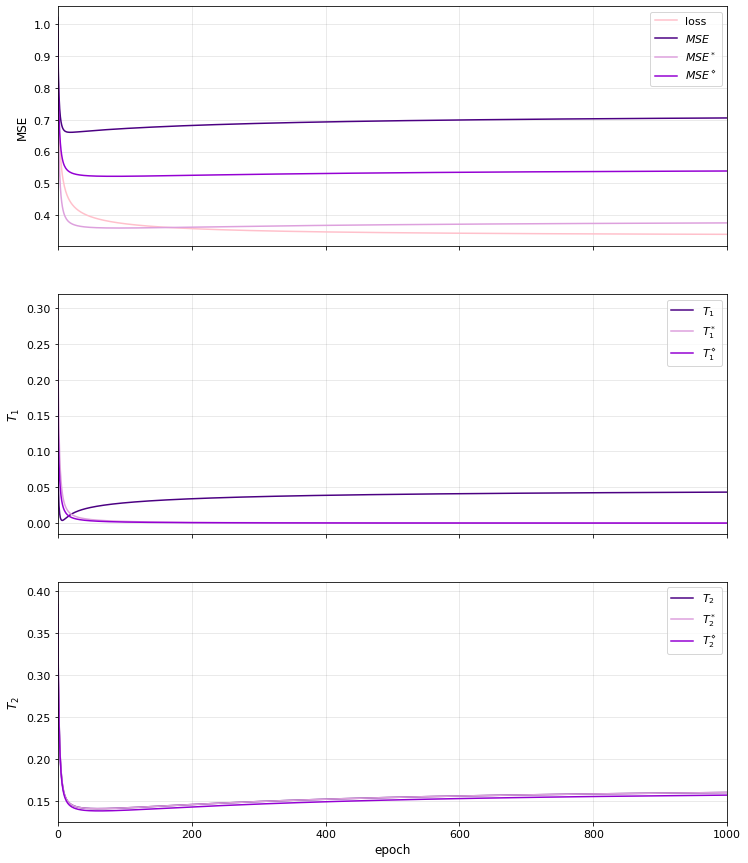

In [14]:
MSE = []
MSE_star =[]
MSE_diamond =[]

for i in range(3000):
    MSE.append(term_I_tab[i] + term_II_tab[i] + 1.0 - term_IV_tab[i])
    MSE_star.append(term_I_star_tab[i] + term_II_star_tab[i] + 1.0 - term_IV_star_tab[i])
    MSE_diamond.append(term_I_diamond_tab[i] + term_II_diamond_tab[i] + 1.0 - term_IV_diamond_tab[i])
    

fig, axs = plt.subplots(3, 1, figsize=(12, 15), sharex=True)

axs[0].plot(np.array(loss_tab)*10, color= 'pink', label = 'loss')

axs[0].plot(MSE, color= 'indigo', label = '$MSE$')
axs[1].plot(term_I_tab, color= 'indigo', label = '$T_1$')
axs[2].plot(term_II_tab, color= 'indigo', label = '$T_2$')
#axs[3].plot(term_IV_tab, color= 'indigo', label = 'original')

axs[0].plot(MSE_star, color= 'plum', label = '$MSE^*$')
axs[1].plot(term_I_star_tab, color= 'plum', label = '$T_1^*$')
axs[2].plot(term_II_star_tab, color= 'plum', label = '$T_2^*$')
#axs[3].plot(term_IV_star_tab, color= 'rebeccapurple', label = '$S^{31}$ improved')

axs[0].plot(MSE_diamond, color= 'darkviolet', label = '$MSE^\diamond$')
axs[1].plot(term_I_diamond_tab, color= 'darkviolet', label = '$T_1^\diamond$')
axs[2].plot(term_II_diamond_tab, color= 'darkviolet', label = '$T_2^\diamond$')
#axs[3].plot(term_IV_diamond_tab, color= 'plum', label = '$S^{11}$ improved')

for ax in axs:
    ax.grid(True, color='gray', alpha = 0.2)
    ax.legend(fontsize=11)
    ax.tick_params(axis='both', labelsize=11)


axs[0].set_ylabel('MSE', fontsize=12)
axs[1].set_ylabel('$T_1$',fontsize=12)
axs[2].set_ylabel('$T_2$',fontsize=12)
axs[-1].set_xlabel('epoch',fontsize=12)
axs[-1].set_xlim(0,1000)